# Notes on fitting the oscillatory particle model to the linear particle model
Tim Tyree<br>
1.15.2022

# Part 1: Results consistent with the mean squared limit

__Notes on fitting the oscillatory particle model to the linear particle model__
To develop a best-fit attraction coefficient of the particle model that is best fit to reproduce the powerlaw annihilation rates, we consider the Langevin equation with inverse-powerlaw attractive forces, $\sim\hat{a}/R$.  We show that $\hat{a}$ can be estimated to be 1/4 times the slope of the mean-squared range (MSR).

...of these interacting particles that attract then and pair-annihilate, we predict for the Fenton-Karma model being modeled by the oscillatory particle model with $\phi_f=\pi/2$, we have the analytical result, $\hat{a}=a$.  This supports the long-time averaged rate of change of MSR for the oscillatory particle model to be equal to that of the linear particle model, 

$$
\hat{a}_{FK}=a.
$$

A direct corollary of $\hat{a}_{FK}=a$ is that the expected annihilation rates are equal, and thus the mean termination time would be equal.

For the Luo-Rudy model, with annihilation phases of $\phi_f=0$, and dynamical period equal to mean lifetime, $T_{LR}=\bar\Gamma_{LR}$, we predict the best fit attraction coefficient of the particle model to be given by

$$
\hat{a}_{LR}=a + D \bigg(\frac{1}{1-\frac{i}{2\pi}} + \frac{1}{1+\frac{i}{2\pi}} \bigg) \approx a + (1.95059...)D.
$$

__Sketch of proof__:
What is the rate of change of MSR averaged over the lifetime of the particle? Let

$$
4\hat{a}\equiv\mathbb{E}_{\Gamma(t)}\Big[\partial_{t}MSR(t)\Big]=\frac{1}{\bar\Gamma}\int_0^\infty dt \Gamma(t) \partial_{t}MSR(t),
$$

where MSR is modeled by
$$
MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
$$

and where $\Gamma(t)$ is modeled by 

$$
\Gamma(t)=\bar\Gamma e^{-t/\bar\Gamma}.
$$

In [1]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# # MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# # DONE: plot ^this model for MSR for fitty parameter settings
# a=3.5;D=1.3;phi_f=0.;period=0.1 #s
# omega=2*np.pi/period
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f)
# plt.plot(t_values,MSR_values_oscillatory)
# plt.show()
# #TODO: plot for both of the full models
# #TODO: compare to the apparent results for MSR from the full models

In [3]:
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [4]:
tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [5]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

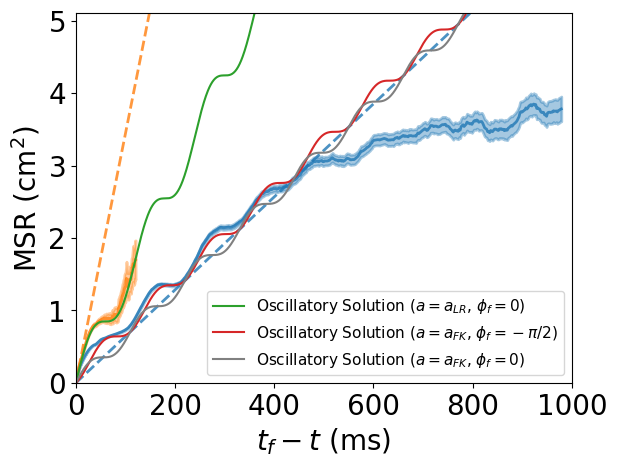

In [6]:
### plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;phi_f=0.;period=0.12 #s
omega=2*np.pi/period
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C2',label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
period=0.11
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C3',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

#what param setting to use for the FK model?
phi_f=0#-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=11)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

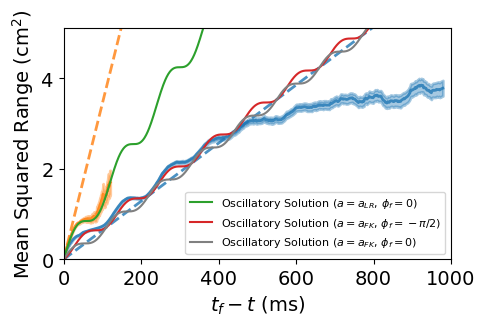

In [7]:
fig,ax=plt.subplots(figsize=(5,3))
# fig,ax=plt.subplots(figsize=(5,3))
### plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;phi_f=0.;period=0.12 #s
omega=2*np.pi/period
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C2',label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
period=0.11
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C3',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

#what param setting to use for the FK model?
phi_f=0#-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'Mean Squared Range (cm$^2$)',fontsize=14)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=8)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [8]:
1

1

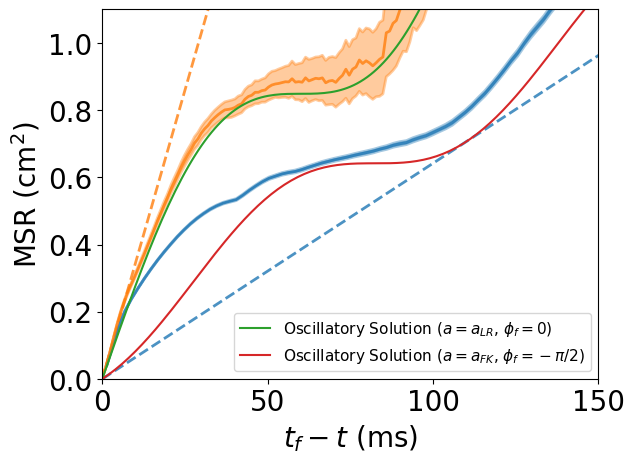

In [9]:
### plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;phi_f=0.;period=0.12 #s
omega=2*np.pi/period
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C2',label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C3',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

#what param setting to use for the FK model?
phi_f=0#-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,150])
plt.ylim([0,1.1])
plt.legend(loc='lower right',fontsize=11)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

$$
\frac{1}{4}MSR(t')=at'+\frac{2D}{\omega}\Big(sin(\omega t' + \phi_f) - sin(\phi_f)\Big)
$$

$$
\hat a = a + D\Big( \frac{e^{i\phi_f}}{1-\frac{i}{\omega \bar\Gamma} } + \frac{e^{-i\phi_f}}{1+\frac{i}{\omega \bar\Gamma} } \Big)
$$

In [10]:
a =3.535902 
period=0.1
barGamma=0.082733
omega=2*np.pi/period
a + a/2*(1.95),a + a/2*(1/(1-1j/(omega*barGamma))+1/(1+1j/(omega*barGamma)))

(6.98340645, (6.945620871389291+0j))

In [11]:
barGamma=.0827333
T_values=np.linspace(0,1,100)
#TODO: plot ^this function 
x_values=T_values/barGamma
ahat_over_a_values=1+0.5*(1/(1-x_values*1j/(2*np.pi)) + 1/(1+x_values*1j/(2*np.pi)))
y_values=ahat_over_a_values

In [12]:
plt.plot(x_values,y_values)
format_plot(ax=plt.gca(),xlabel=r'$T/\bar \Gamma$',ylabel=r'$\hat a/a$')

True

In [13]:
120/80

1.5

In [14]:
1+0.5*(1/(1-3j/(4*np.pi)) + 1/(1+3j/(4*np.pi)))

(1.9460799107856646+0j)

In [15]:
8.5/1.946


4.367934224049332

In [16]:
1+1.*(1/(1-3j/(4*np.pi)) + 1/(1+3j/(4*np.pi)))

(2.892159821571329+0j)

In [17]:
8.5/2.89

2.941176470588235

In [18]:
# ahat_LR_over_a_LR
x=2*np.pi*84/120
# x=1
1+0.5*(1/(1-1j*x)-1/(1+1j*x))/1j


(1.2161884543726833+0j)

In [19]:
# ahat_FK_over_a_LR
x=2*np.pi*310/110
# x=1
1+0.5*(-1j/(1-1j*x)-1j/(1+1j*x))/1j


(0.9968207891439963+0j)

In [20]:
8.5/1.216

6.990131578947369

In [21]:
(-1j/(1-1j*x)+1j/(1+1j*x))/1


(0.1125895816554413+0j)

## next logical step: determine if plugging ahat into the particle model gives the annihilation rates of the full models

$$
\hat a = a + \mathcal{J}D
$$

Where $\mathcal{J}_{FK}=0.112...$ and $\mathcal{J}_{LR}=1.95...$.

If $a=1.60...$ and $D=a/2$, then $\hat a_{FK}=1.69...$.

If $a=3.50...$ and $D=a/2$, then $\hat a_{LR}=6.91...$.

In [22]:
1.60*(1+0.5*0.112)

1.6896000000000002

In [23]:
3.50*(1+0.5*1.95)

6.9125000000000005

Contradiction...? I only found particle model solutions for 
$a \ge ~8.25$...

In [24]:
3.50*(1+1*1.95)

10.325000000000001

In [25]:
#maybe if I searched for larger D in the annihilation rates of the linear particle model?


## DONE: cointegrate the distribution of lifetimes with the mean squared range, as measured from the LR model

In [26]:
# import cudf

In [27]:
import pickle

lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

# with open(lifetime_pdf_dir, 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(lifetime_pdf_dir, 'rb') as handle:
    dict_lifetimes = pickle.load(handle)


TODO(prereq): copy solution estimating ahat --> $\infty$ of z=Gammabar/T --> $0$ from iPad
$$
\hat{a}=a_{osc.} + \mathcal{J}(z;\phi_f) D_{osc.}
$$

__Sketch of Proof__

Let the mean-squared range (MSR) is the approximate solution to the the mean-squared, large sample limit of the the SDE corresponding to the oscillatory particle model

For $4\hat{a}\bar\Gamma \equiv \mathbb{E}_{\Gamma(t;\bar\Gamma)}\Big[\text{MSR}_{osc.}(t;T,a_{osc.},D_{osc.})\Big]$, we have

$$
\mathcal{J}(z;\phi_f) = \frac{e^{i\phi_f}}{1-2\pi iz} + \frac{e^{-i\phi_f}}{1+2\pi iz}.
$$

- DONE: checked ^the ansatz matches what I used on my iPad.

One can see that as $z\rightarrow0$, $\mathcal{J}(z;\phi_f) \rightarrow ??$.


TODO: estimate the z that gives ahat=<the ones I used in Fig. 1>.  For now, let
- ahat_LR=8.5, $\phi_f=0$
- ahat_FK=1.6, $\phi_f=-\pi/2$

# Part 2: Results consistent with the mean squared power spectrum limit

__Results from the mean squared power spectrum hypothesis__

The ansatz that demands self-consistency with respect to the mean squared power spectrum results in the following equation:
$$
\hat a^2 = a^2 + \delta a_\text{diffusion}^2 + \delta a_{\text{diffusion  }\times \text{ drift}}^2
$$

Where $\hat a$ is the effective attraction coefficient and $a$ is the attraction coefficient involved with the oscillatory model.  There emerged two correction factors. One was purely due to diffusion, $\delta a_\text{diffusion}$.  The other was due to the interaction between diffusion and drift, $\delta a_{\text{diffusion  }\times \text{ drift}}$.

## Plot the analytic solution for $\hat a$=ahat resulting from the mean squared power spectrum

In [92]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [93]:
def correction_diffusion(z,a,D,phi):
    """
    correction_diffusion returns the real correction value 
    that evaluates the expected attraction coefficient 
    in terms of the parameters of the oscilatory model 
    relative to the lifetime of the particle.
    
    here, the lifetime of the particle has been taken 
    to be exponentially distributed 
    with an expected value 
    proportional to z.
    
    Note that z is also 
    inversely proportional 
    to the dynamic period of oscillation.
    """
    dasum=np.sin(phi)-2.*np.sin(phi)**2
    dasum+=(1+4.*a**2+2.*z**2.*z*np.sin(2.*phi)-np.cos(2.*phi))/(2.+8.*z**2)
    dahat=2.*D**2/z**2
    dahat*=dasum
    return dahat

def correction_diffusion_lr(z,a):
    """
    correction_diffusion_lr returns the correction 
    to the attraction coefficient due to diffusion 
    as the float expected 
    in the mean squared power spectrum limit 
    for parameters fit to the Luo-Rudy model.
    """
    return correction_diffusion(z,a,a/2.,phi=0.)

def correction_diffusion_fk(z,a):
    """
    correction_diffusion_lr returns the correction 
    to the attraction coefficient due to diffusion 
    as the float expected 
    in the mean squared power spectrum limit 
    for parameters fit to the Fenton-Karma model.
    """
    return correction_diffusion(z,a,a/2.,phi=-np.pi/2.)

In [94]:
#heretim

In [95]:
a_hat_lr=8.5
a_hat_fk=1.6
print(F"TODO: add blue and orange curves for the a values expected of the full solution")
dz=0.1#0.01
z_values=np.arange(dz,3+dz,dz)
sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)

TODO: add blue and orange curves for the a values expected of the full solution


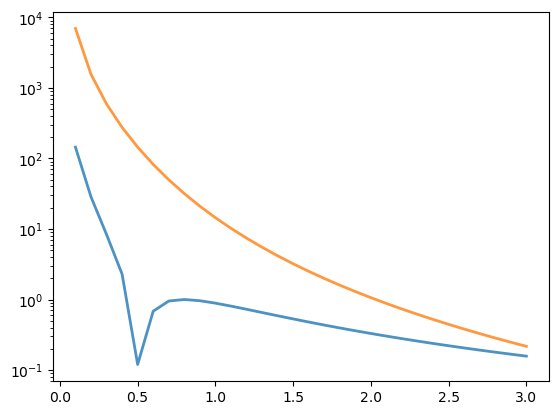

In [96]:
x_values=z_values.copy()
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
plt.yscale('log')
plt.show()

In [113]:
a_hat_lr=8.5
a_hat_fk=1.6
print(F"TODO: add blue and orange curves for the a values expected of the full solution")
dz=0.01
z_values=np.arange(dz,3+dz,dz)
sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)
#compute plotting values
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
c_values=a_values_trgt/np.max(a_values_trgt)
vmin=np.min(c_values)
vmax=np.max(c_values)

TODO: add blue and orange curves for the a values expected of the full solution


In [114]:
#DONE: plot dahat_over_a versus z
da=0.002#0.01
a_values=np.arange(da,4+da,da)

#eval correction_diffusion_lr
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_lr(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values_lr=dahat_values.copy()

#eval correction_diffusion_fk
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_fk(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values_fk=dahat_values.copy()

In [115]:
# test dahat_over_a_lr is nonnegative for diffusion term
assert not (dahat_values_lr<0).any()

# test dahat_over_a_lr has negative values for diffusion term
assert (dahat_values_fk<0).any()

In [116]:
#DONE: visualize these traces for either model for ahat correction versus 2pi*(lifetime / dynamic period) as z
x_values=z_values.copy()/(2.*np.pi)
a_values_trgt=a_values[::40]#for  a_values.shape as (400,)
y_values_fk_lst=[]
y_values_lr_lst=[]
for a  in a_values_trgt:
    boo=a==a_values
    #compute
    y_values_fk=dahat_values_fk.T[boo][0]
    y_values_lr=dahat_values_lr.T[boo][0]
    #record
    y_values_fk_lst.append(y_values_fk)
    y_values_lr_lst.append(y_values_lr)

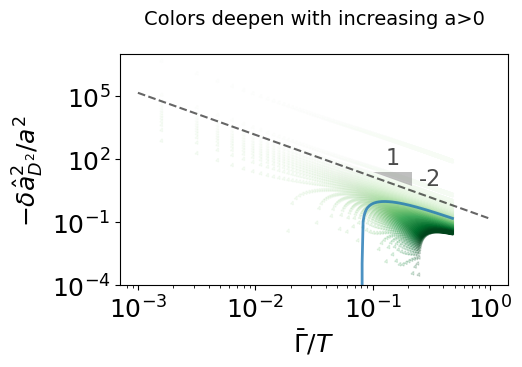

In [122]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,-y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,-y_values_lr,lw=2,alpha=0.8)
# #plot for variable a
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# c_values=a_values_trgt/np.max(a_values_trgt)
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

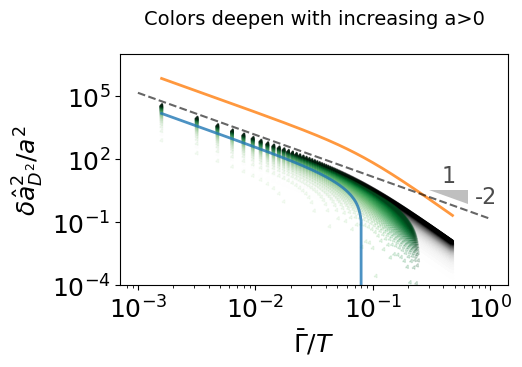

In [119]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

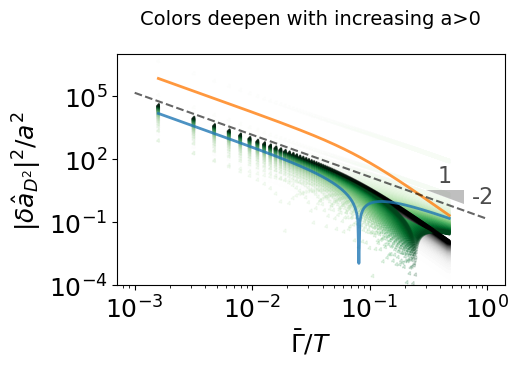

In [121]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,np.abs(y_values_fk_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,np.abs(y_values_lr_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

# TODO: repeat ^that for the cross correction term
HINT: did I already implement it? try tab to find out!

In [126]:
#TODO(Now!): implement the cross correction to ahat_squared
def correction_cross(z,a,D,phi):
    """
    correction_cross returns the real correction value 
    that evaluates the expected attraction coefficient 
    in terms of the parameters of the oscilatory model 
    relative to the lifetime of the particle.
    
    here, the lifetime of the particle has been taken 
    to be exponentially distributed 
    with an expected value 
    proportional to z.
    
    Note that z is also 
    inversely proportional 
    to the dynamic period of oscillation.
    """
    dasum=(np.sin(phi)+2.*z*np.cos(phi)-z**2*np.sin(phi))/((1.+z**2)**2)
    dasum-=np.sin(phi)
    dahat=D/z
    dahat*=dasum
    return dahat

def correction_cross_lr(z,a):
    """
    correction_diffusion_lr returns the cross correction 
    to the attraction coefficient 
    as the float expected 
    in the mean squared power spectrum limit 
    for parameters fit to the Luo-Rudy model.
    """
    return correction_cross(z,a,a/2.,phi=0.)

def correction_cross_fk(z,a):
    """
    correction_diffusion_lr returns the cross correction 
    to the attraction coefficient 
    as the float expected 
    in the mean squared power spectrum limit 
    for parameters fit to the Fenton-Karma model.
    """
    return correction_cross(z,a,a/2.,phi=-np.pi/2.)

In [127]:
#TODO: test thes functions with the equations on my ipad
#TODO: test thes functions with the following

In [ ]:
kkk

TODO: add blue and orange curves for the a values expected of the full solution


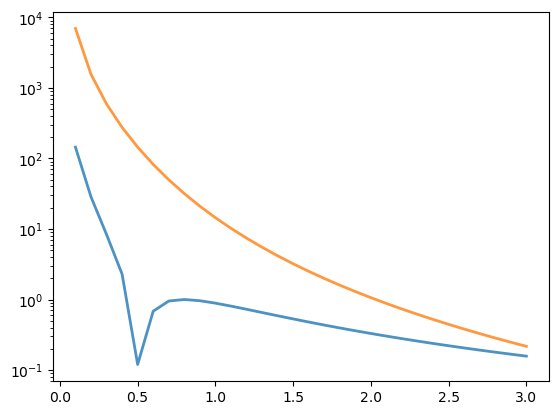

TODO: add blue and orange curves for the a values expected of the full solution


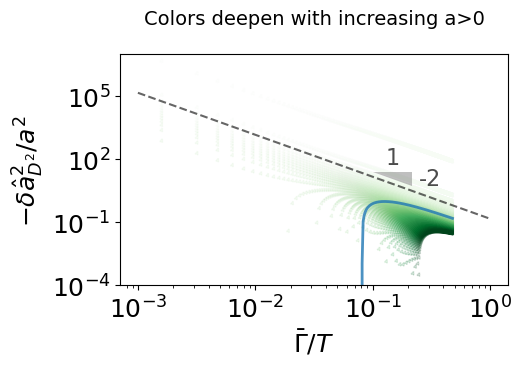

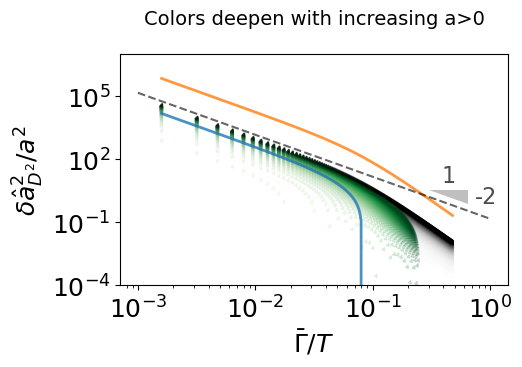

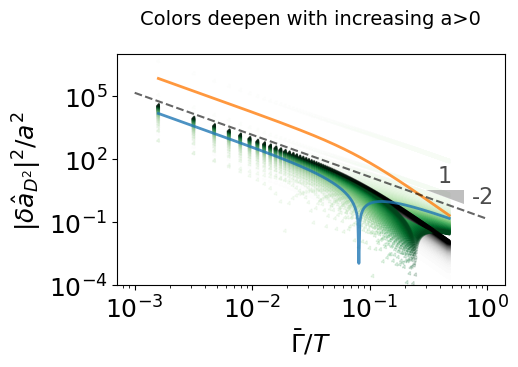

In [123]:
# #reset matplotlib
# import matplotlib
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# def correction_diffusion(z,a,D,phi):
#     """
#     correction_diffusion returns the real correction value 
#     that evaluates the expected attraction coefficient 
#     in terms of the parameters of the oscilatory model 
#     relative to the lifetime of the particle.
    
#     here, the lifetime of the particle has been taken 
#     to be exponentially distributed 
#     with an expected value 
#     proportional to z.
    
#     Note that z is also 
#     inversely proportional 
#     to the dynamic period of oscillation.
#     """
#     dasum=np.sin(phi)-2.*np.sin(phi)**2
#     dasum+=(1+4.*a**2+2.*z**2.*z*np.sin(2.*phi)-np.cos(2.*phi))/(2.+8.*z**2)
#     dahat=2.*D**2/z**2
#     dahat*=dasum
#     return dahat

# def correction_diffusion_lr(z,a):
#     """
#     correction_diffusion_lr returns the correction 
#     to the attraction coefficient due to diffusion 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Luo-Rudy model.
#     """
#     return correction_diffusion(z,a,a/2.,phi=0.)

# def correction_diffusion_fk(z,a):
#     """
#     correction_diffusion_lr returns the correction 
#     to the attraction coefficient due to diffusion 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Fenton-Karma model.
#     """
#     return correction_diffusion(z,a,a/2.,phi=-np.pi/2.)

# a_hat_lr=8.5
# a_hat_fk=1.6
# print(F"TODO: add blue and orange curves for the a values expected of the full solution")
# dz=0.1#0.01
# z_values=np.arange(dz,3+dz,dz)
# sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
# sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)

# x_values=z_values.copy()
# #plot the expected solutions
# y_values_lr=sdahat_values_lr/a_hat_lr**2
# y_values_fk=sdahat_values_fk/a_hat_fk**2
# plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# plt.yscale('log')
# plt.show()

# a_hat_lr=8.5
# a_hat_fk=1.6
# print(F"TODO: add blue and orange curves for the a values expected of the full solution")
# dz=0.01
# z_values=np.arange(dz,3+dz,dz)
# sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
# sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)
# #compute plotting values
# y_values_lr=sdahat_values_lr/a_hat_lr**2
# y_values_fk=sdahat_values_fk/a_hat_fk**2
# c_values=a_values_trgt/np.max(a_values_trgt)
# vmin=np.min(c_values)
# vmax=np.max(c_values)

# #DONE: plot dahat_over_a versus z
# da=0.002#0.01
# a_values=np.arange(da,4+da,da)

# #eval correction_diffusion_lr
# dahat_lst=[]
# for a in a_values:
#     dahat=correction_diffusion_lr(z_values,a)
#     dahat_lst.append(dahat)
# # dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values_lr=dahat_values.copy()

# #eval correction_diffusion_fk
# dahat_lst=[]
# for a in a_values:
#     dahat=correction_diffusion_fk(z_values,a)
#     dahat_lst.append(dahat)
# # dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values_fk=dahat_values.copy()

# # test dahat_over_a_lr is nonnegative for diffusion term
# assert not (dahat_values_lr<0).any()

# # test dahat_over_a_lr has negative values for diffusion term
# assert (dahat_values_fk<0).any()

# #DONE: visualize these traces for either model for ahat correction versus 2pi*(lifetime / dynamic period) as z
# x_values=z_values.copy()/(2.*np.pi)
# a_values_trgt=a_values[::40]#for  a_values.shape as (400,)
# y_values_fk_lst=[]
# y_values_lr_lst=[]
# for a  in a_values_trgt:
#     boo=a==a_values
#     #compute
#     y_values_fk=dahat_values_fk.T[boo][0]
#     y_values_lr=dahat_values_lr.T[boo][0]
#     #record
#     y_values_fk_lst.append(y_values_fk)
#     y_values_lr_lst.append(y_values_lr)

# slope=-2#-1/4
# alpha=0.2
# xlabel=r'$\bar\Gamma / T$'#
# ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
# #DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# # DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
# #plot the expected solutions
# y_values_lr=sdahat_values_lr/a_hat_lr**2
# y_values_fk=sdahat_values_fk/a_hat_fk**2
# plt.plot(x_values,-y_values_fk,lw=2,alpha=0.8)
# plt.plot(x_values,-y_values_lr,lw=2,alpha=0.8)
# # #plot for variable a
# #plot for variable a
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# # c_values=a_values_trgt/np.max(a_values_trgt)
# # for i,a in enumerate(a_values_trgt):
# #     plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# #     plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# # TODO: each colored by a_values_trgt 
# # TODO: on a scale with both ends clearly visible

# #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# #HINT: y = M * x **-nu for nu as the negative slope
# xv=np.logspace(-3,0,100)
# yv=1.5e-1*xv**slope
# plt.plot(xv,yv,'k--',alpha=.6)

# #format_plot
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# # plt.yscale('log')
# plt.ylim([1e-4,1e7])
# format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# plt.show()

# slope=-2#-1/4
# alpha=0.2
# xlabel=r'$\bar\Gamma / T$'#
# ylabel=r'$\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
# # ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# # ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# #DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# # DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
# #plot the expected solutions
# plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
# plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# #plot for variable a
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# #     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# #     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# # TODO: each colored by a_values_trgt 
# # TODO: on a scale with both ends clearly visible
# #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# #HINT: y = M * x **-nu for nu as the negative slope
# xv=np.logspace(-3,0,100)
# yv=1.5e-1*xv**slope
# plt.plot(xv,yv,'k--',alpha=.6)

# #format_plot
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# # plt.yscale('log')
# plt.ylim([1e-4,1e7])
# format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# # mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# plt.show()

# slope=-2#-1/4
# alpha=0.2
# xlabel=r'$\bar\Gamma / T$'#
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# #DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# # DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
# #plot the expected solutions
# plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# #plot for variable a
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,np.abs(y_values_fk_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,np.abs(y_values_lr_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# #     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# #     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# # TODO: each colored by a_values_trgt 
# # TODO: on a scale with both ends clearly visible
# #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# #HINT: y = M * x **-nu for nu as the negative slope
# xv=np.logspace(-3,0,100)
# yv=1.5e-1*xv**slope
# plt.plot(xv,yv,'k--',alpha=.6)

# #format_plot
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# # plt.yscale('log')
# plt.ylim([1e-4,1e7])
# format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# # mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# plt.show()

## TODO: look for a mean lifetime that is consistent with an exponentially distributed lifetime and the MSD of the full model

In [42]:
#TODO: compute 3.5/1.6 
expected_ahat_squared_ratio= (3.5/1.6 )**2
print(f"expected_ahat_squared_ratio={expected_ahat_squared_ratio}")

expected_ahat_squared_ratio=4.78515625


## scratchwerk

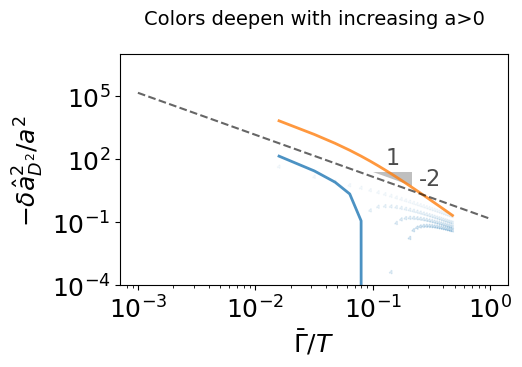

In [79]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
#plot for variable a
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible



#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

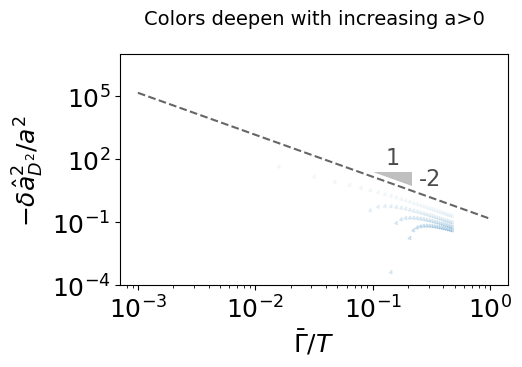

In [37]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'# (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

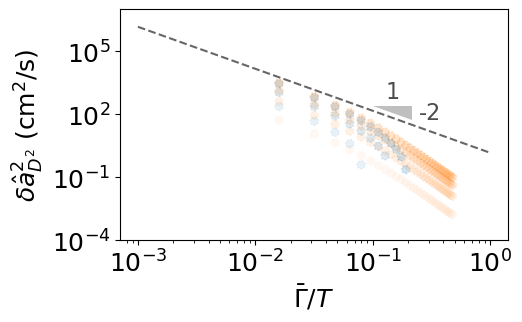

In [38]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{D^2} ^2$ (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,y_values_fk_lst[i],c='C0',linestyle='dotted',alpha=alpha*c_values[i])
    plt.scatter(x_values,y_values_lr_lst[i],c='C1',linestyle='dotted',alpha=alpha*c_values[i])
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e0*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e2, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

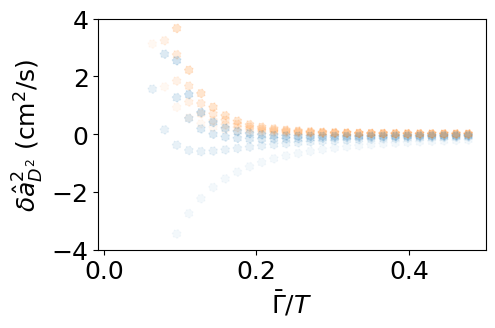

TODO: change the variable a lines to use two clearly distinguishable color schemes that end at both ends as clearly distinguishable from white background
TODO: add blue and orange curves for the a values expected of the full solution


In [39]:
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    ax.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i])
    ax.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i])
 
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

# #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# #HINT: y = M * x **-nu for nu as the negative slope
# xv=np.logspace(-3,0,100)
# yv=1.5e-1*xv**slope
# plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([-4,4e0])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=False, fontsize=18)#, **kwargs)
# format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()
print(f"TODO: change the variable a lines to use two clearly distinguishable color schemes that end at both ends as clearly distinguishable from white background")
print(F"TODO: add blue and orange curves for the a values expected of the full solution")

In [40]:
#TODO: change ^this plot to only use give values for a_hat_lr and a_hat_fk
# slope=-2#-1/4
# alpha=0.2
# xlabel=r'$\bar\Gamma / T$'#
# ylabel=r'$\delta \hat a_{D^2} ^2/a^2$ (cm$^2$/s)'
# #DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# # DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
# c_values=a_values_trgt/np.max(a_values_trgt)
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i])
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i])
# # TODO: each colored by a_values_trgt 
# # TODO: on a scale with both ends clearly visible

# # #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# # #HINT: y = M * x **-nu for nu as the negative slope
# # xv=np.logspace(-3,0,100)
# # yv=1.5e-1*xv**slope
# # plt.plot(xv,yv,'k--',alpha=.6)

# #format_plot
# # plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# # plt.yscale('log')
# # plt.ylim([1e-4,1e7])
# # format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=False, fontsize=18)#, **kwargs)
# # format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# # mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# plt.show()

In [41]:
# def mark_slope(ax, x1, y1, slope=(2, 1),
#         text_kwargs={'color': 'black'},
#         poly_kwargs={'facecolor': (0., 0., 0)},
#         **kwargs):
#     '''all parameters are passed to mpltools.annotation.slope_marker
#     slope can equivalently be, for example, 2 or (2,1).

#     Example Usage:
# mark_slope(ax, x1, y1)
# #...or better yet
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
#     '''
#     annotation.slope_marker(origin=(x1, y1),
#                             slope=slope,
#                             text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                             poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                             ax=ax)
#     return True

In [46]:
#TODO(later): plot the ratio of the difference between lr and fk for the diffusion correction to ahat_squared

In [45]:
#TODO(Now!): plot the cross correction to ahat_squared